In [2]:
import torch 
from torch import nn

from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

### Getting the dataset

The dataset used is Fashion MNIST from torchvision datasets.

In [3]:
# Setup the training data

train_data = datasets.FashionMNIST(
    root="data", # Where to download data to
    train=True, 
    download=True,
    transform=ToTensor(), # Convert to tensors
    target_transform=None
)

# Setup the test data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [4]:
image, label = train_data[0]
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {label}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: 9


In [5]:
class_names = train_data.classes
class_names
print(f"Class names: {class_names}")
print(f"Class the image belongs to: {class_names[label]}")

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Class the image belongs to: Ankle boot


In [6]:
# Get a dictionary of class names and their corresponding indices

class_to_idx = train_data.class_to_idx
class_to_idx


{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

### Visualising the data

Displaying the image and as expected, it is an image of an ankle boot.

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]


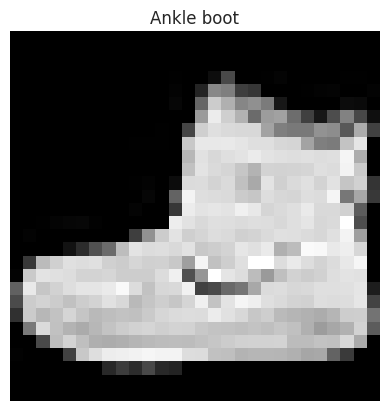

In [8]:
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
plt.show()

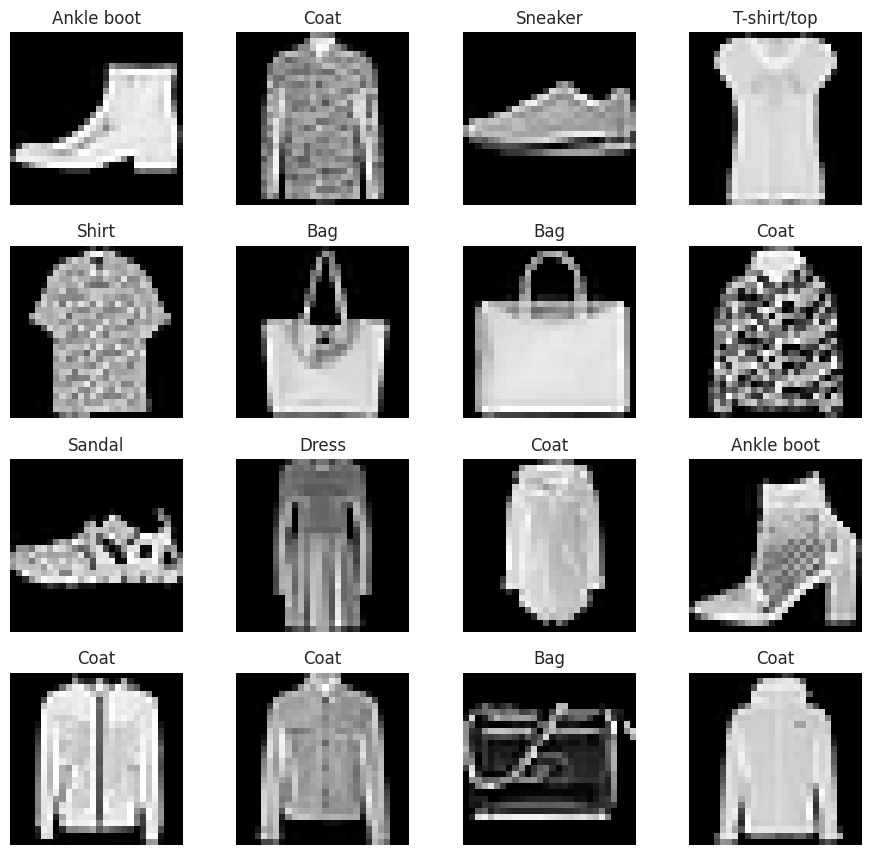

In [9]:
# Displaying more images
# torch.manual_seed(101)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    fig.tight_layout()
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)
plt.show()

In [10]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

### Prepare DataLoader 

Right now, the data is in the form of PyTorch datasets.

DataLoader turns the dataset into Python iterables.
More specifically, turn the data into batches (or mini batches).

- To make it more computationally efficient.
- Break it down to 32 images at a time (batch_size=32)
- Gives more chances to neural networks to update its gradients per epoch.

In [11]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True # Shuffle the data to remove any order
)

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fd2938bb620>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd2938b7c50>)

In [12]:
# Checking out how many batches we have in the training and test dataloaders

print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fd2938bb620>, <torch.utils.data.dataloader.DataLoader object at 0x7fd2938b7c50>)
Length of train_dataloader: 1875 batches of 32...
Length of test_dataloader: 313 batches of 32...


In [13]:
# What is inside the training dataloader?
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Label: T-shirt/top


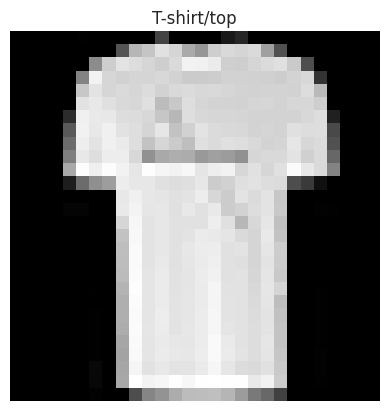

In [14]:
# Show a sample
torch.manual_seed(101)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
image, label = train_features_batch[random_idx], train_labels_batch[random_idx]
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Label: {class_names[label]}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
plt.show()

#### Creating device agnostic code

In [15]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'cuda'

### Classical ML methods

- Logistic Regression

In [16]:
# Hyperparameters
LEARNING_RATE = 0.1
NUM_EPOCHS = 15

In [17]:
import torch.nn.functional as F

class OVRLogisticRegression(nn.Module):
    def __init__(self, input_dim: int, n_classes: int):
        super().__init__()
        self.classifier = nn.Linear(input_dim, n_classes)
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten the input
        return self.classifier(x)

model_lr = OVRLogisticRegression(input_dim=28*28, n_classes=len(class_names)).to(device)
model_lr

OVRLogisticRegression(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)

In [18]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_lr.parameters(), lr=LEARNING_RATE)

In [19]:
# Training loop
train_losses, test_losses = [], []

for epoch in range(1, NUM_EPOCHS + 1):
    model_lr.train()

    train_loss = 0
    train_correct = 0

    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        y_one_hot = F.one_hot(y, num_classes=len(class_names)).float().to(device)
        logits = model_lr(X)

        loss = criterion(logits, y_one_hot)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (logits.argmax(dim=1) == y).sum().item()

    train_loss /= len(train_dataloader)
    train_acc = train_correct / len(train_dataloader.dataset)

    model_lr.eval()
    test_loss = 0
    test_correct = 0

    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)

            y_one_hot = F.one_hot(y_test, num_classes=len(class_names)).float().to(device)
            test_logits = model_lr(X_test)

            test_loss += criterion(test_logits, y_one_hot).item()
            test_correct += (test_logits.argmax(dim=1) == y_test).sum().item()

    test_loss /= len(test_dataloader)
    test_acc = test_correct / len(test_dataloader.dataset)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(
        f"Epoch: {epoch}/{NUM_EPOCHS} | "
        f"Train loss: {train_loss:.4f} | "
        f"Train acc: {train_acc:.4f} | "
        f"Test loss: {test_loss:.4f} | "
        f"Test acc: {test_acc:.4f}"
    )

print(f"Training Complete | Final Training Loss: {train_losses[-1]:.4f} | Final Test Loss: {test_losses[-1]:.4f}")

Epoch: 1/15 | Train loss: 0.1627 | Train acc: 0.7258 | Test loss: 0.1325 | Test acc: 0.7619
Epoch: 2/15 | Train loss: 0.1209 | Train acc: 0.7937 | Test loss: 0.1178 | Test acc: 0.7898
Epoch: 3/15 | Train loss: 0.1109 | Train acc: 0.8092 | Test loss: 0.1114 | Test acc: 0.8034
Epoch: 4/15 | Train loss: 0.1055 | Train acc: 0.8178 | Test loss: 0.1071 | Test acc: 0.8114
Epoch: 5/15 | Train loss: 0.1020 | Train acc: 0.8235 | Test loss: 0.1044 | Test acc: 0.8151
Epoch: 6/15 | Train loss: 0.0994 | Train acc: 0.8270 | Test loss: 0.1023 | Test acc: 0.8171
Epoch: 7/15 | Train loss: 0.0973 | Train acc: 0.8312 | Test loss: 0.1008 | Test acc: 0.8198
Epoch: 8/15 | Train loss: 0.0957 | Train acc: 0.8321 | Test loss: 0.0993 | Test acc: 0.8237
Epoch: 9/15 | Train loss: 0.0944 | Train acc: 0.8359 | Test loss: 0.0982 | Test acc: 0.8261
Epoch: 10/15 | Train loss: 0.0932 | Train acc: 0.8367 | Test loss: 0.0971 | Test acc: 0.8272
Epoch: 11/15 | Train loss: 0.0923 | Train acc: 0.8383 | Test loss: 0.0961 | Tes

True Label: Shirt | Pred Label: Shirt | Pred Prob: 0.4578


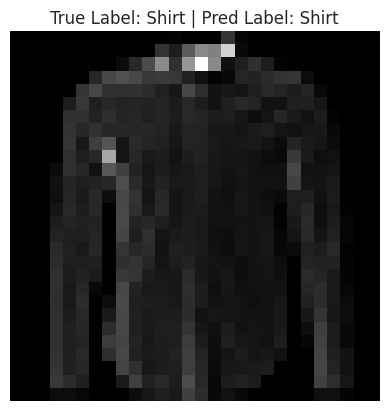

In [20]:
model_lr.eval()
sample_idx = torch.randint(0, len(test_dataloader), size=[1]).item()
sample_image, sample_label = test_data[sample_idx]

with torch.inference_mode():
    logits = model_lr(sample_image.unsqueeze(0).to(device))
    pred_prob = torch.sigmoid(logits).squeeze().cpu()

pred_label = int(torch.argmax(pred_prob).item())

print(f"True Label: {class_names[sample_label]} | Pred Label: {class_names[pred_label]} | Pred Prob: {pred_prob[pred_label]:.4f}")
plt.imshow(sample_image.squeeze(), cmap="gray")
plt.title(f"True Label: {class_names[sample_label]} | Pred Label: {class_names[pred_label]}")
plt.axis(False)
plt.show()

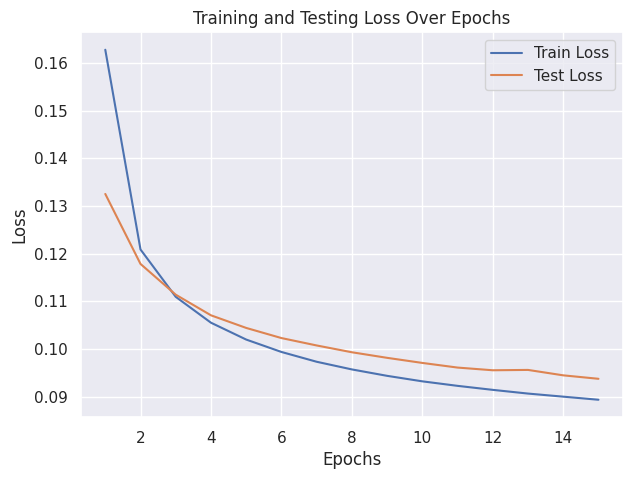

In [22]:
import seaborn as sns

sns.set_style(style="darkgrid")
plt.figure(figsize=(7, 5))
sns.lineplot(x=range(1, NUM_EPOCHS + 1), y=train_losses, label="Train Loss")
sns.lineplot(x=range(1, NUM_EPOCHS + 1), y=test_losses, label="Test Loss")
plt.title("Training and Testing Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

As we have established that the data is not linearly separable and we are only getting around 82 % test accuracy using One vs rest logistic regression, i decided to use Support Vector Machines with Kernels.

### Support Vector Machine with RBF Kernel

Using SVM with RBF (Radial Basis Function) kernel for non-linear classification.
Will use GridSearchCV to find optimal hyperparameters (C and gamma).


In [23]:
# Import necessary libraries for SVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from timeit import default_timer as timer
import pandas as pd

In [24]:
# Prepare data for sklearn SVM
# Convert PyTorch datasets to numpy arrays and flatten images

# Extract training data
X_train = train_data.data.numpy()
y_train = train_data.targets.numpy()

# Extract test data
X_test = test_data.data.numpy()
y_test = test_data.targets.numpy()

# Flatten the images from 28x28 to 784
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Training data shape: {X_train_flat.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test_flat.shape}")
print(f"Test labels shape: {y_test.shape}")


Training data shape: (60000, 784)
Training labels shape: (60000,)
Test data shape: (10000, 784)
Test labels shape: (10000,)


In [25]:
# Normalize the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

print("Data normalized successfully")
print(f"Training data mean: {X_train_scaled.mean():.4f}, std: {X_train_scaled.std():.4f}")


Data normalized successfully
Training data mean: -0.0000, std: 1.0000


In [26]:
# Use a subset for GridSearch (SVM is computationally expensive on large datasets)
# Using 10,000 samples for faster hyperparameter tuning
subset_size = 10000
np.random.seed(101)
subset_indices = np.random.choice(len(X_train_scaled), subset_size, replace=False)

X_train_subset = X_train_scaled[subset_indices]
y_train_subset = y_train[subset_indices]

print(f"Subset size for GridSearch: {X_train_subset.shape}")


Subset size for GridSearch: (10000, 784)


In [27]:
# Define the parameter grid for GridSearch
# C: Regularization parameter
# gamma: Kernel coefficient for 'rbf'
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

print("Parameter grid for GridSearch:")
print(param_grid)


Parameter grid for GridSearch:
{'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]}


In [28]:
# Perform GridSearchCV
print("Starting GridSearchCV...")
print("="*60)

start_time = timer()

# Create SVM classifier with RBF kernel
svm_rbf = SVC(kernel='rbf', random_state=101)

# Create GridSearchCV object
# cv=3 for 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=svm_rbf,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train_subset, y_train_subset)

end_time = timer()
print("="*60)
print(f"GridSearch completed in {end_time - start_time:.2f} seconds")


Starting GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END .................................C=0.1, gamma=0.001; total time= 1.5min
[CV] END .................................C=0.1, gamma=scale; total time= 1.5min
[CV] END ..................................C=0.1, gamma=auto; total time= 1.5min
[CV] END ..................................C=0.1, gamma=auto; total time= 1.5min
[CV] END .................................C=0.1, gamma=0.001; total time= 1.5min
[CV] END ..................................C=0.1, gamma=auto; total time= 1.5min
[CV] END .................................C=0.1, gamma=0.001; total time= 1.5min
[CV] END .................................C=0.1, gamma=scale; total time= 1.6min
[CV] END .................................C=0.1, gamma=scale; total time= 1.6min
[CV] END ...................................C=1, gamma=scale; total time= 1.0min
[CV] END ...................................C=1, gamma=scale; total time= 1.1min
[CV] END ..............

In [29]:
# Display best parameters and score
print("Best parameters found by GridSearch:")
print(grid_search.best_params_)
print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")

# Get detailed results
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
results_df = results_df.sort_values('rank_test_score')
print("\nTop 5 parameter combinations:")
print(results_df.head())


Best parameters found by GridSearch:
{'C': 10, 'gamma': 0.001}

Best cross-validation score: 0.8650

Top 5 parameter combinations:
                          params  mean_test_score  std_test_score  \
14     {'C': 10, 'gamma': 0.001}           0.8650        0.004106   
13    {'C': 10, 'gamma': 'auto'}           0.8641        0.004467   
12   {'C': 10, 'gamma': 'scale'}           0.8637        0.004825   
19   {'C': 100, 'gamma': 'auto'}           0.8598        0.004645   
18  {'C': 100, 'gamma': 'scale'}           0.8595        0.004842   

    rank_test_score  
14                1  
13                2  
12                3  
19                4  
18                5  


In [30]:
# Train final model on full training data with best parameters
print("Training final SVM model on full training data with best parameters...")
print("="*60)

start_time = timer()

# Create SVM with best parameters
best_svm = SVC(
    kernel='rbf',
    C=grid_search.best_params_['C'],
    gamma=grid_search.best_params_['gamma'],
    random_state=101
)

# Train on full training data
best_svm.fit(X_train_scaled, y_train)

end_time = timer()
print(f"Training completed in {end_time - start_time:.2f} seconds")
print("="*60)


Training final SVM model on full training data with best parameters...
Training completed in 169.36 seconds


In [31]:
# Evaluate on training and test data
train_predictions = best_svm.predict(X_train_scaled)
test_predictions = best_svm.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.9736
Test Accuracy: 0.8970


In [32]:
# Detailed classification report
print("Classification Report:")
print("="*60)
print(classification_report(y_test, test_predictions, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.85      0.84      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.81      0.82      0.82      1000
       Dress       0.90      0.91      0.90      1000
        Coat       0.83      0.83      0.83      1000
      Sandal       0.97      0.97      0.97      1000
       Shirt       0.75      0.71      0.73      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.96      0.98      0.97      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



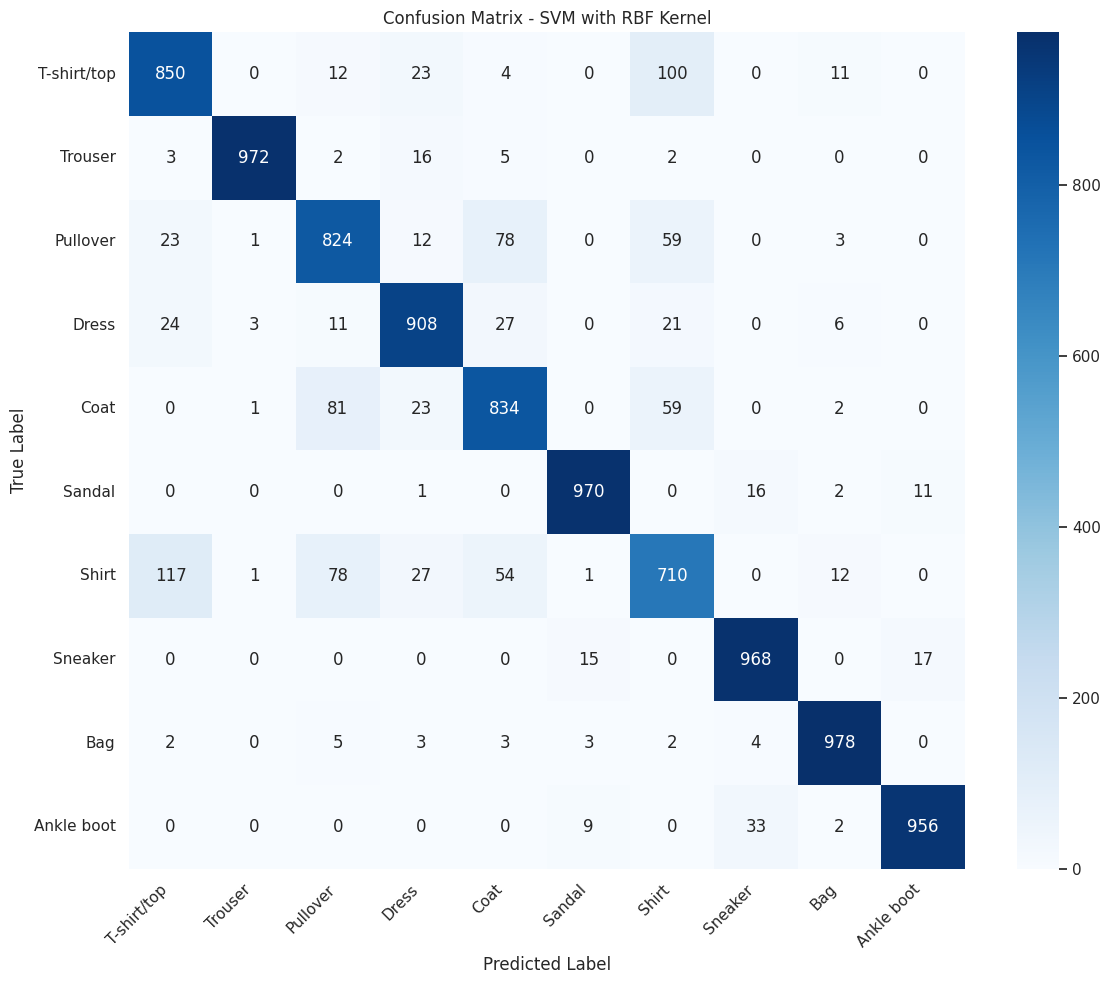

In [33]:
# Visualize confusion matrix
cm = confusion_matrix(y_test, test_predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - SVM with RBF Kernel')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


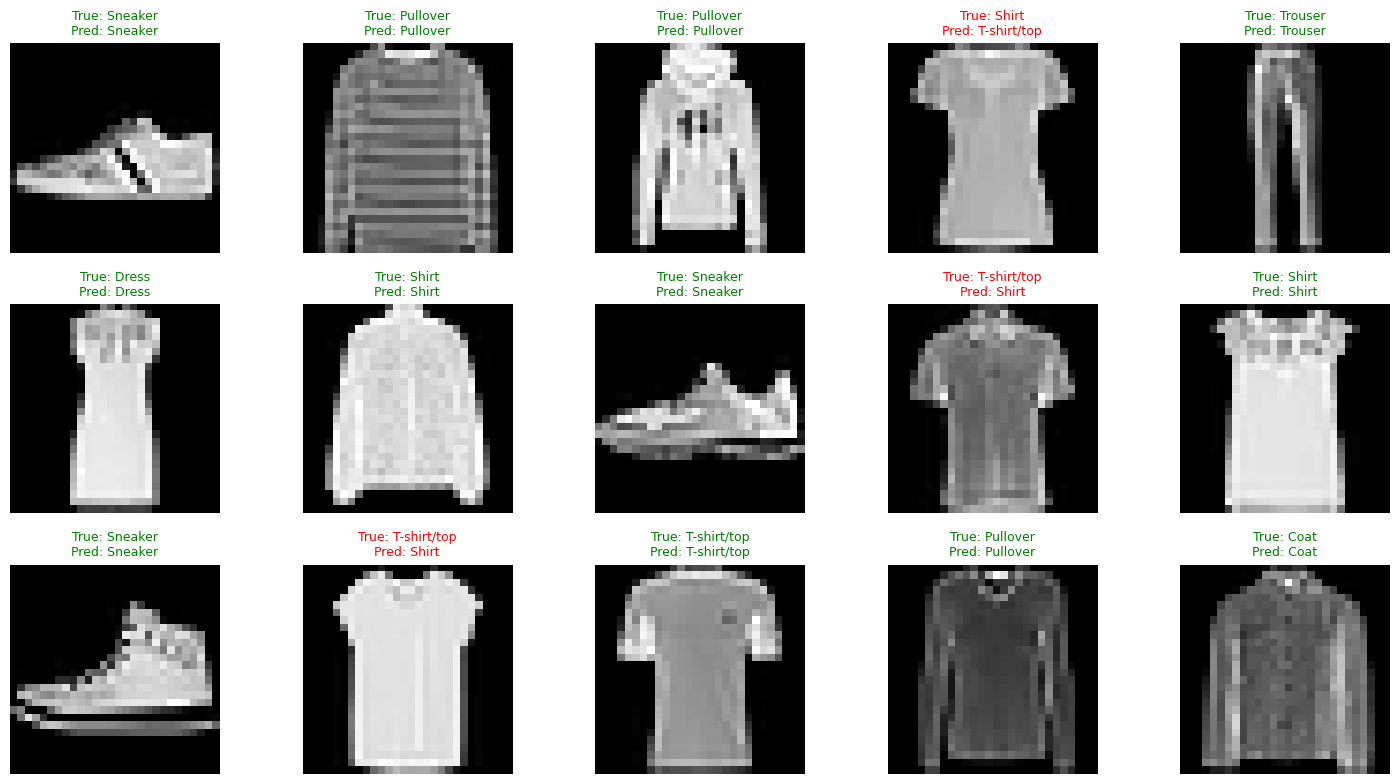

In [34]:
# Visualize some predictions
np.random.seed(101)
fig = plt.figure(figsize=(15, 8))
rows, cols = 3, 5

for i in range(1, rows * cols + 1):
    random_idx = np.random.randint(0, len(X_test))
    
    # Get image and prediction
    img = X_test[random_idx]
    true_label = y_test[random_idx]
    pred_label = test_predictions[random_idx]
    
    # Create subplot
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap="gray")
    
    # Color title based on correct/incorrect prediction
    title_color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", 
              color=title_color, fontsize=9)
    plt.axis(False)

plt.tight_layout()
plt.show()


In [35]:
# Model Summary
print("="*60)
print("SVM RBF Kernel Model Summary")
print("="*60)
print(f"Best Hyperparameters: C={grid_search.best_params_['C']}, gamma={grid_search.best_params_['gamma']}")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("="*60)
print("\nComparison with Logistic Regression:")
print(f"Logistic Regression Test Accuracy: 0.8309")
print(f"SVM RBF Test Accuracy: {test_accuracy:.4f}")
print(f"Improvement: {test_accuracy - 0.8309:.4f}")
print("="*60)

SVM RBF Kernel Model Summary
Best Hyperparameters: C=10, gamma=0.001
Training Accuracy: 0.9736
Test Accuracy: 0.8970

Comparison with Logistic Regression:
Logistic Regression Test Accuracy: 0.8309
SVM RBF Test Accuracy: 0.8970
Improvement: 0.0661


### K-Nearest Neighbors (KNN)

Using KNN classifier for Fashion MNIST.
Will test different k values and use cross-validation to find the optimal k.


In [37]:
# Import KNN classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


In [38]:
# Test different k values to find optimal k
# Using a smaller subset for faster computation
subset_size_knn = 5000
np.random.seed(101)
knn_subset_indices = np.random.choice(len(X_train_scaled), subset_size_knn, replace=False)

X_train_knn_subset = X_train_scaled[knn_subset_indices]
y_train_knn_subset = y_train[knn_subset_indices]

print(f"Using subset of {subset_size_knn} samples for k optimization")

# Test k values from 1 to 15
k_values = [1, 3, 5, 7, 9, 11, 13, 15]
k_scores = []

print("\nTesting different k values...")
print("="*60)

for k in k_values:
    start_time = timer()
    
    # Create KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    
    # Perform 3-fold cross-validation
    scores = cross_val_score(knn, X_train_knn_subset, y_train_knn_subset, cv=3, scoring='accuracy')
    mean_score = scores.mean()
    k_scores.append(mean_score)
    
    end_time = timer()
    
    print(f"k={k:2d} | Mean CV Accuracy: {mean_score:.4f} | Time: {end_time - start_time:.2f}s")

print("="*60)


Using subset of 5000 samples for k optimization

Testing different k values...
k= 1 | Mean CV Accuracy: 0.7870 | Time: 0.19s
k= 3 | Mean CV Accuracy: 0.7992 | Time: 0.16s
k= 5 | Mean CV Accuracy: 0.8024 | Time: 0.15s
k= 7 | Mean CV Accuracy: 0.7976 | Time: 0.15s
k= 9 | Mean CV Accuracy: 0.7902 | Time: 0.15s
k=11 | Mean CV Accuracy: 0.7878 | Time: 0.15s
k=13 | Mean CV Accuracy: 0.7872 | Time: 0.15s
k=15 | Mean CV Accuracy: 0.7860 | Time: 0.15s


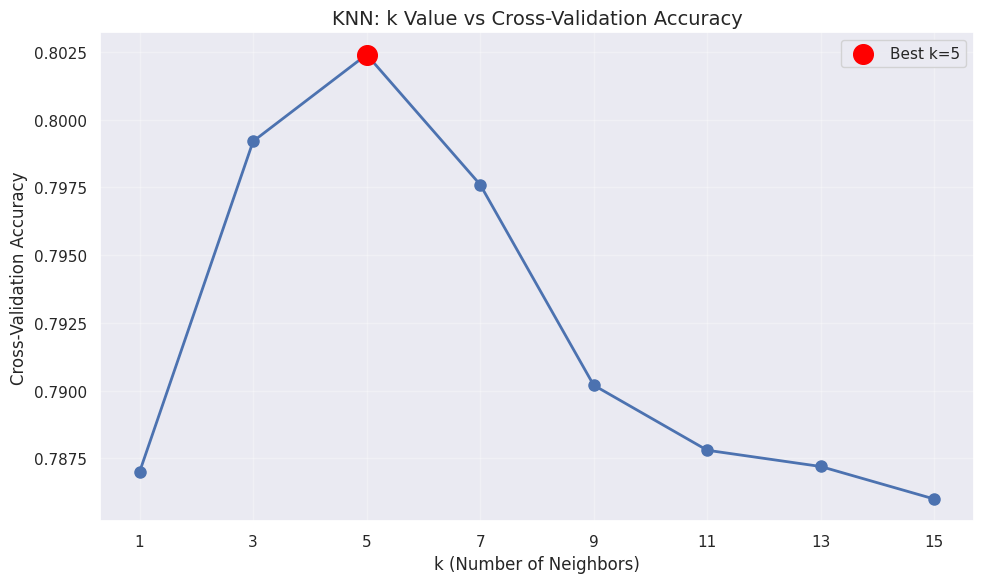

Best k value: 5
Best cross-validation accuracy: 0.8024


In [39]:
# Visualize k values vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_values, k_scores, marker='o', linewidth=2, markersize=8)
plt.xlabel('k (Number of Neighbors)', fontsize=12)
plt.ylabel('Cross-Validation Accuracy', fontsize=12)
plt.title('KNN: k Value vs Cross-Validation Accuracy', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

# Mark the best k
best_k_idx = np.argmax(k_scores)
best_k = k_values[best_k_idx]
best_score = k_scores[best_k_idx]
plt.scatter(best_k, best_score, color='red', s=200, zorder=5, label=f'Best k={best_k}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best k value: {best_k}")
print(f"Best cross-validation accuracy: {best_score:.4f}")


In [40]:
# Train KNN on full training data with best k
print(f"Training KNN with k={best_k} on full training data...")
print("="*60)

start_time = timer()

# Create KNN classifier with best k
knn_final = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)

# Train on full training data
knn_final.fit(X_train_scaled, y_train)

end_time = timer()
print(f"Training completed in {end_time - start_time:.2f} seconds")
print("="*60)


Training KNN with k=5 on full training data...
Training completed in 0.02 seconds


In [41]:
# Make predictions
print("Making predictions on test data...")
start_time = timer()

knn_test_predictions = knn_final.predict(X_test_scaled)

end_time = timer()
print(f"Prediction completed in {end_time - start_time:.2f} seconds")

# Calculate accuracy
knn_train_predictions = knn_final.predict(X_train_scaled)
knn_train_accuracy = accuracy_score(y_train, knn_train_predictions)
knn_test_accuracy = accuracy_score(y_test, knn_test_predictions)

print(f"\nTraining Accuracy: {knn_train_accuracy:.4f}")
print(f"Test Accuracy: {knn_test_accuracy:.4f}")


Making predictions on test data...
Prediction completed in 3.22 seconds

Training Accuracy: 0.9011
Test Accuracy: 0.8533


In [42]:
# Detailed classification report for KNN
print("Classification Report (KNN):")
print("="*60)
print(classification_report(y_test, knn_test_predictions, target_names=class_names))


Classification Report (KNN):
              precision    recall  f1-score   support

 T-shirt/top       0.77      0.86      0.81      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.74      0.80      0.77      1000
       Dress       0.90      0.86      0.88      1000
        Coat       0.77      0.77      0.77      1000
      Sandal       0.99      0.84      0.91      1000
       Shirt       0.64      0.59      0.61      1000
     Sneaker       0.88      0.96      0.92      1000
         Bag       0.98      0.93      0.95      1000
  Ankle boot       0.90      0.96      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



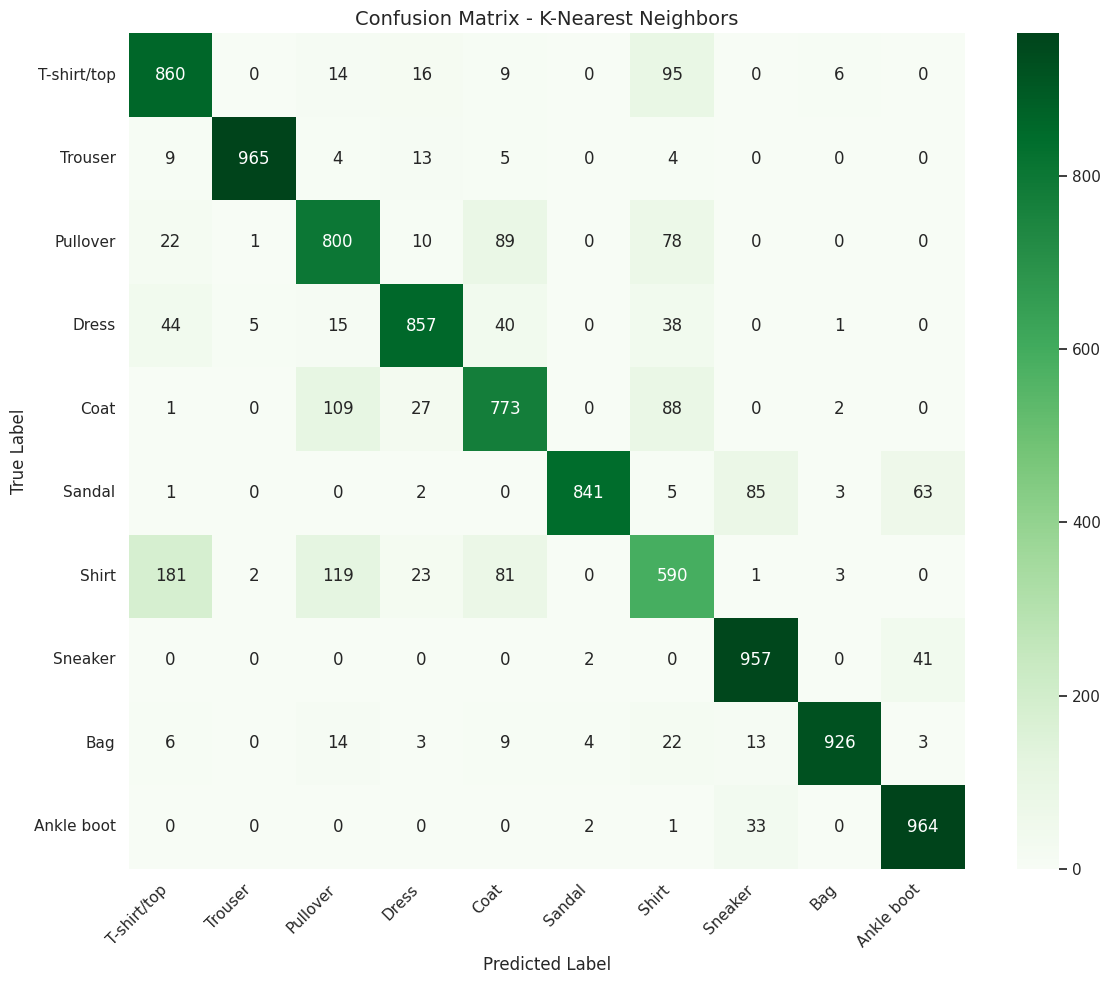

In [43]:
# Visualize confusion matrix for KNN
knn_cm = confusion_matrix(y_test, knn_test_predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - K-Nearest Neighbors', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


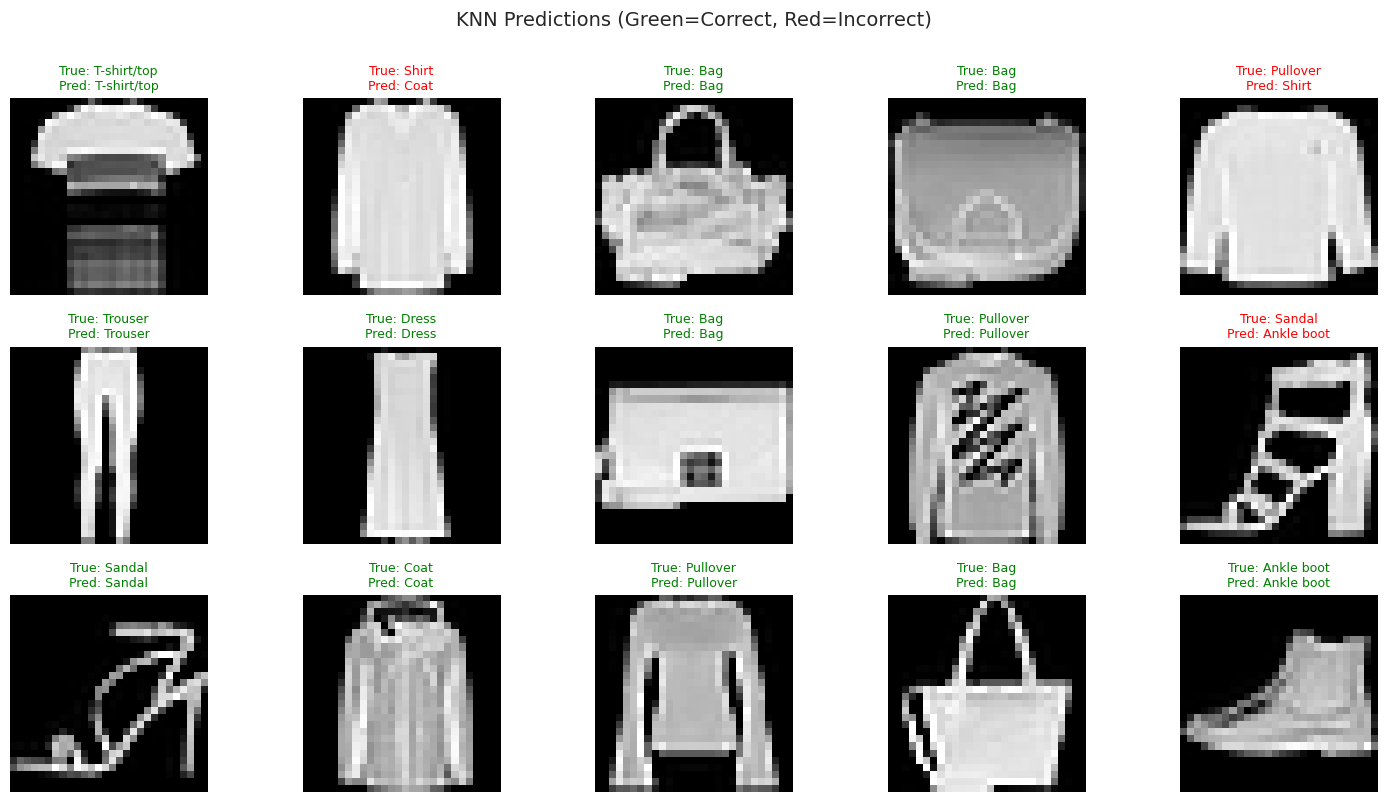

In [44]:
# Visualize some predictions from KNN
np.random.seed(42)
fig = plt.figure(figsize=(15, 8))
rows, cols = 3, 5

for i in range(1, rows * cols + 1):
    random_idx = np.random.randint(0, len(X_test))
    
    # Get image and prediction
    img = X_test[random_idx]
    true_label = y_test[random_idx]
    pred_label = knn_test_predictions[random_idx]
    
    # Create subplot
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap="gray")
    
    # Color title based on correct/incorrect prediction
    title_color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", 
              color=title_color, fontsize=9)
    plt.axis(False)

plt.suptitle('KNN Predictions (Green=Correct, Red=Incorrect)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()


In [45]:
# KNN Model Summary and Comparison
print("="*60)
print("K-Nearest Neighbors Model Summary")
print("="*60)
print(f"Best k value: {best_k}")
print(f"Training Accuracy: {knn_train_accuracy:.4f}")
print(f"Test Accuracy: {knn_test_accuracy:.4f}")
print("="*60)

# Comparison with other models
print("\n" + "="*60)
print("Model Comparison Summary")
print("="*60)
models_comparison = {
    'Logistic Regression': 0.8309,
    'SVM RBF Kernel': 0.8970,
    'K-Nearest Neighbors': knn_test_accuracy
}

for model_name, accuracy in models_comparison.items():
    print(f"{model_name:25s}: {accuracy:.4f}")

print("="*60)
best_model = max(models_comparison, key=models_comparison.get)
print(f"Best Model: {best_model} with {models_comparison[best_model]:.4f} accuracy")
print("="*60)


K-Nearest Neighbors Model Summary
Best k value: 5
Training Accuracy: 0.9011
Test Accuracy: 0.8533

Model Comparison Summary
Logistic Regression      : 0.8309
SVM RBF Kernel           : 0.8970
K-Nearest Neighbors      : 0.8533
Best Model: SVM RBF Kernel with 0.8970 accuracy


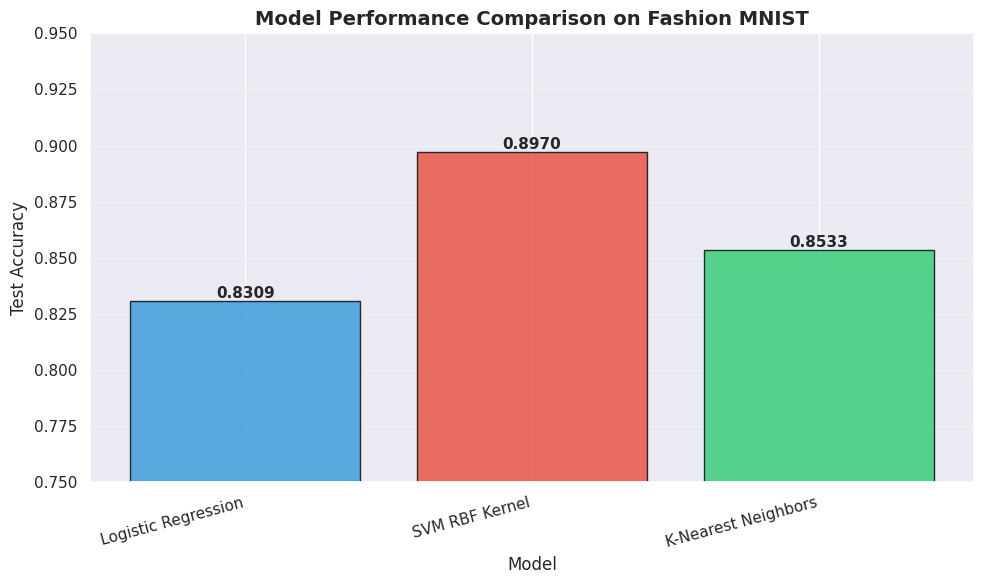

In [46]:
# Visualize model comparison
plt.figure(figsize=(10, 6))
models = list(models_comparison.keys())
accuracies = list(models_comparison.values())

bars = plt.bar(models, accuracies, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black')

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Model', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Model Performance Comparison on Fashion MNIST', fontsize=14, fontweight='bold')
plt.ylim([0.75, 0.95])
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### Model 0: Baseline Model

Simple model -> Will try and improve upon with subsequent models/experiments.

In other words, start simply and add complexity if necessary

In [69]:
from torch import nn

# Model Architecture
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [76]:
torch.manual_seed(42)

# Create an instance of the model
model_0 = FashionMNISTModelV0(
    input_shape=28 * 28, # 28*28 = 784
    hidden_units=10, 
    output_shape=len(class_names)
).to(device)

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [77]:
dummy_x = torch.rand([1, 1, 28, 28]).to(device)
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], device='cuda:0', grad_fn=<AddmmBackward0>)

### Setup loss, optimizer and evaluation metrics

* Loss function - since we are working with multi class data, our loss function should be `nn.CrossEntropyLoss()`

* Optimiser - our optimizer `torch.optim.SGD()` Stochastic Gradient Descent.

* Evaluation Metric - Since we are working on classification problem, let's use accuracy as an evaluation metric. 
 

In [78]:
LEARNING_RATE = 0.1 # Tweaked each epoch

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=LEARNING_RATE)

### Time the experiements

In [79]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on device {device}: {total_time:.3f} seconds")
    return total_time

Common Accuracy Function

In [80]:
def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### Creating a training loop and training the model on batches of data

- Loop through epochs.
- Loop through training batches, perform training steps, calculating the train loss *per batch*
- Loop through testing batches, perform testing steps, calculate the test loss *per batch*
- Print out what is happening.
- Time it all 

In [81]:
from tqdm.auto import tqdm

# Set seed and start timer
torch.manual_seed(42)
train_time = timer()

# Set the number of epochs
NUM_EPOCHS = 3  # Start with 3 for testing, increase to 10-15 later

# Creating a training loop and training the model on batches of data
for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}\n---------")
    
    ### Training
    train_loss = 0
    train_correct = 0  # Track correct predictions across ALL batches
    
    model_0.train()  # Set to training mode ONCE before loop
    
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        # Move data to device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model_0(X)

        # Calculate loss per batch
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # Calculate correct predictions for this batch
        train_correct += (y_pred.argmax(dim=1) == y).sum().item()

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimiser step
        optimizer.step()

        # Print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    # Calculate average train loss and accuracy across ALL batches
    train_loss /= len(train_dataloader)
    train_acc = train_correct / len(train_dataloader.dataset)

    ### Testing
    test_loss = 0
    test_correct = 0  # Track correct predictions across ALL batches
    
    model_0.eval()

    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # Move data to device
            X_test, y_test = X_test.to(device), y_test.to(device)
            
            # Make predictions
            test_pred = model_0(X_test)

            # Calculate loss per batch
            test_loss += loss_fn(test_pred, y_test).item()
            
            # Calculate correct predictions for this batch
            test_correct += (test_pred.argmax(dim=1) == y_test).sum().item()
            
    # Calculate average test loss and accuracy across ALL batches
    test_loss /= len(test_dataloader)
    test_acc = test_correct / len(test_dataloader.dataset)

    # Print out what's happening with proper formatting
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}\n")

# Calculate the training time
train_time_end = timer()
print_train_time(start=train_time, end=train_time_end)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1/3
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 33%|███▎      | 1/3 [00:02<00:04,  2.30s/it]

Train loss: 0.5904 | Train acc: 0.7917 | Test loss: 0.5095 | Test acc: 0.8203

Epoch: 2/3
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 67%|██████▋   | 2/3 [00:04<00:02,  2.29s/it]

Train loss: 0.4763 | Train acc: 0.8332 | Test loss: 0.4799 | Test acc: 0.8318

Epoch: 3/3
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


100%|██████████| 3/3 [00:06<00:00,  2.29s/it]

Train loss: 0.4550 | Train acc: 0.8405 | Test loss: 0.4766 | Test acc: 0.8341

Train time on device cuda: 6.869 seconds


6.8693883118685335

### Make predictions and get Model 0 inference

In [84]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn, device: torch.device = device):
    """
    Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): The model to evaluate.
        data_loader (torch.utils.data.DataLoader): The data loader to evaluate the model on.
        loss_fn (torch.nn.Module): The loss function to evaluate the model on.
        accuracy_fn (function): The accuracy function to evaluate the model on.
        device (torch.device): The device to evaluate the model on.

    Returns:
        (dict): A dictionary containing the results of the model predicting on the data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

In [85]:
model_0_results = eval_model(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
model_0_results

100%|██████████| 313/313 [00:00<00:00, 1212.00it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

### Model 1: Building a better model with non-linearity

In [ ]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # 28 *28 -> 784
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(), # Add a non-linear activation function
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU() # Add a non-linear activation function
        )
        
    def forward(self, x):
        return self.layer_stack(x)